In [1]:
!pip install transformers[torch]
!pip install datasets evaluate numpy pandas matplotlib seaborn nltk scikit-learn openpyxl imbalanced-learn seqeval

In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is accessible
print(torch.cuda.get_device_name(0))  # Displays your GPU name

True
NVIDIA GeForce RTX 3090


In [3]:
import pandas as pd
import numpy as np
import os
import torch
import string
import re
from torch.optim import AdamW
from torch.utils.data import DataLoader
from evaluate import load
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler, Trainer, TrainingArguments

from datasets import Dataset, concatenate_datasets, DatasetDict

from sklearn.metrics import ConfusionMatrixDisplay

# Dataset

In [4]:
df_cnn_path = 'dataset_cnn_10k.xlsx'
df_kompas_path = 'dataset_kompas_4k.xlsx'
df_tempo_path = 'dataset_tempo_6k.xlsx'
df_tbh_path = 'dataset_turnbackhoax_10k.xlsx'

df_cnn = pd.read_excel(df_cnn_path) # dataset CNN
df_kompas = pd.read_excel(df_kompas_path) # dataset Kompas
df_tempo = pd.read_excel(df_tempo_path) # dataset Tempo
df_tbh = pd.read_excel(df_tbh_path) # dataset TurnBackHoax

In [5]:
df_cnn

,Title,Timestamp,FullText,Tags,Author,Url
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,"Selasa, 21 Feb 2023 21:22 WIB","Jakarta, CNN Indonesia -- Mantan Gubernur DKI ...",anies baswedan;pengajian;pilpres 2024;badan ko...,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,"Selasa, 21 Feb 2023 20:46 WIB","Medan, CNN Indonesia -- Gubernur Sumatera Utar...",edy rahmayadi;pemilu 2024;pilkada 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,"Selasa, 21 Feb 2023 20:33 WIB","Jakarta, CNN Indonesia -- Partai Kebangkitan B...",ida fauziyah;pkb;pemilu 2024;pileg 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapres,"Selasa, 21 Feb 2023 19:58 WIB","Jakarta, CNN Indonesia -- Ketua Umum Partai Ke...",gede pasek suardika;ahy;pilpres 2024;pemilu 20...,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,"Selasa, 21 Feb 2023 18:56 WIB","Jakarta, CNN Indonesia -- Dewan Pimpinan Pusat...",anas urbaningrum;pkn;pemilu 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...
...,...,...,...,...,...,...
9995,Jokowi Wanti-wanti Ekspansi Ideologi Transnasi...,"Selasa, 01 Jun 2021 11:07 WIB","Jakarta, CNN Indonesia -- Presiden Joko Widodo...",jokowi;hari lahir pancasila;5g;ideologi,ulf | CNN Indonesia,https://www.cnnindonesia.com/nasional/20210601...
9996,PBNU: Tak ada Pertentangan antara Islam dan Pa...,"Selasa, 01 Jun 2021 10:40 WIB","Jakarta, CNN Indonesia -- Di momen Hari Lahir ...",pbnu;hari lahir pancasila,ryh | CNN Indonesia,https://www.cnnindonesia.com/nasional/20210601...
9997,Jokowi Bicara Ideologi Transnasional di Revolu...,"Selasa, 01 Jun 2021 10:06 WIB","Jakarta, CNN Indonesia -- Presiden Joko Widodo...",pancasila;jokowi,ulf | CNN Indonesia,https://www.cnnindonesia.com/nasional/20210601...
9998,"Hari Lahir Pancasila, Jokowi Waspadai Rivalita...","Selasa, 01 Jun 2021 09:34 WIB","Jakarta, CNN Indonesia -- Presiden Joko Widodo...",pancasila;hari lahir pancasila;jokowi,CNN Indonesia,https://www.cnnindonesia.com/nasional/20210601...


In [6]:
df_kompas

,Title,Timestamp,FullText,Tags,Author,Url
0,"Efek Ekor Jas Pencalonan Anies, Elektabilitas ...","21 Februari 2023, 15:30 WIB",Hasil jajak pendapat yang diselenggarakan Litb...,Survei Litbang Kompas;Elektabilitas Nasdem Nai...,NaN,https://video.kompas.com/watch/258152/efek-eko...
1,"Ekonomi 2024 Ditargetkan Tumbuh 5,7 Persen, pa...","Kompas.com - 21/02/2023, 14:22 WIB","JAKARTA, KOMPAS.com - Pemerintah menargetkan p...",Jakarta;Ekonomi 2024,Penulis Yohana Artha Uly | Editor Aprillia Ika,http://money.kompas.com/read/2023/02/21/142238...
2,"Survei Litbang Kompas: PDI-P, Gerindra, dan Go...","21 Februari 2023, 09:58 WIB","PDI-Perjuangan, Partai Gerindra, dan Partai Go...",Pdip;Pdi Perjuangan;Gerindra;Golkar;Demokrat;N...,NaN,https://video.kompas.com/watch/257988/survei-l...
3,"Survei Litbang ""Kompas"": Popularitas Golkar Te...","Kompas.com - 21/02/2023, 05:23 WIB","JAKARTA, KOMPAS.com - Survei Litbang Kompas Ja...",Litbang Kompas;survei kepemimpinan nasional;su...,Penulis Tatang Guritno | Editor Bagus Santosa,http://nasional.kompas.com/read/2023/02/21/052...
4,"""Endorsement"" dan Basa-basi Politik ala Jokowi...","Kompas.com - 21/02/2023, 05:20 WIB","JAKARTA, KOMPAS.com - Presiden Joko Widodo la...",capres pemilu 2024;jokowi dukung ganjar;jokowi...,Penulis Fitria Chusna Farisa | Editor Fitria C...,http://nasional.kompas.com/read/2023/02/21/052...
...,...,...,...,...,...,...
4745,Nurul Arifin Ajak Perempuan Terjun ke Dunia Po...,"Kompas.com - 21/04/2017, 16:41 WIB","JAKARTA, KOMPAS.com - Ketua DPP Partai Golkar ...",Kartini;Film Kartini;RA Kartini;Nurul Arifin,Penulis Ihsanuddin | EditorInggried Dwi Wedhas...,http://nasional.kompas.com/read/2017/04/21/164...
4746,Kebangkitan Lawan Politik Jokowi...,"Kompas.com - 21/04/2017, 11:33 WIB","JAKARTA, KOMPAS.com - Pasangan Anies Baswedan-...",Pilpres 2019;Prabowo Subianto;Jokowi,Penulis Ihsanuddin | EditorSandro Gatra,http://nasional.kompas.com/read/2017/04/21/113...
4747,Ridwan Kamil Akui Pilkada DKI Berdampak pada S...,"Kompas.com - 20/04/2017, 16:45 WIB","BANDUNG, KOMPAS.com - Wali Kota Bandung Ridwan...",Ridwan Kamil;Pilkada DKI,"Penulis Kontributor Bandung, Dendi Ramdhani | ...",http://regional.kompas.com/read/2017/04/20/164...
4748,Anies Belum Berpikir Apakah Akan Menjadi Anggo...,"Kompas.com - 20/04/2017, 14:41 WIB","JAKARTA, KOMPAS.com - Calon gubernur DKI Jakar...",Anies Baswedan-Sandiaga Uno,Penulis David Oliver Purba | EditorEgidius Pat...,http://megapolitan.kompas.com/read/2017/04/20/...


In [7]:
df_tempo

,Title,Timestamp,FullText,Tags,Author,Url
0,Ma'ruf Amin akan Saksikan Lagi Timnas Indonesi...,"Sabtu, 1 Januari 2022 17:14 WIB","TEMPO.CO, Jakarta - Wakil Presiden Ma'ruf Amin...",Ma'ruf Amin;Piala AFF 2020;Indonesia vs Thaila...,Reporter Egi Adyatama Editor Aditya Budiman,https://nasional.tempo.co/read/1545504/maruf-a...
1,Menag Yaqut Canangkan 2022 Sebagai Tahun Toler...,"Sabtu, 1 Januari 2022 15:05 WIB","TEMPO.CO, Jakarta - Menteri Agama Yaqut Cholil...",Menag;Yaqut Cholil Qoumas;Gus Yaqut;Toleransi;...,Reporter Egi Adyatama Editor Aditya Budiman,https://nasional.tempo.co/read/1545477/menag-y...
2,Jokowi Ajak Masyarakat Hadapi 2022 dengan Sema...,"Sabtu, 1 Januari 2022 12:05 WIB","TEMPO.CO, Jakarta - Presiden Joko Widodo atau ...",Jokowi;2022;Pandemi Covid-19;Resesi,Reporter Antara Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1545437/jokowi-...
3,"Top Nasional: Strategi Hadapi Omicron, Lemhana...","Sabtu, 1 Januari 2022 07:28 WIB","TEMPO.CO, Jakarta - Berita yang banyak menarik...",Omicron;Lemhanas;Kemenkes;WHO;Agus Widjojo,Reporter Tempo.co Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1545377/top-nas...
4,"Mulai Tahun Ini, Menteri Tjahjo Kumolo Minta P...","Sabtu, 1 Januari 2022 07:02 WIB","TEMPO.CO, Jakarta - Menteri Pendayagunaan Apar...",Tjahjo Kumolo;Menpan RB;ASN;PNS;protokol keseh...,Reporter Friski Riana Editor Syailendra Persada,https://nasional.tempo.co/read/1545310/mulai-t...
...,...,...,...,...,...,...
6587,5 Fakta dan Kasak-kusuk Jabatan Gubernur Diusu...,"Sabtu, 4 Februari 2023 10:10 WIB","TEMPO.CO, Jakarta -Wakil Ketua DPR RI Muhaimin...",Gubernur;Gubernur Jawa Barat;Ridwan Kamil;Sult...,Reporter Hendrik Khoirul Muhid Editor Dwi Arjanto,https://nasional.tempo.co/read/1687515/5-fakta...
6588,Komentari soal PDIP Enggan Berkoalisi dengan P...,"Sabtu, 4 Februari 2023 08:36 WIB","TEMPO.CO, Jakarta - Ketua DPP Partai NasDem Wi...",PDIP;NasDem;Impor;Hasto;Syahrul Yasin Limpo,Reporter Ima Dini Shafira Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1687528/komenta...
6589,Top Nasional: NasDem Bilang Piagam Deklarasi K...,"Sabtu, 4 Februari 2023 07:54 WIB","TEMPO.CO, Jakarta - Berita yang menarik perhat...",Koalisi Perubahan;NasDem;PKS;Surya Paloh;Luhut,Reporter Tempo.co Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1687524/top-nas...
6590,NasDem Sebut Demokrat Tak Ngotot Sodorkan AHY ...,"Sabtu, 4 Februari 2023 06:50 WIB","TEMPO.CO, Jakarta - Ketua DPP Partai NasDem Su...",AHY;Anies;Demokrat;NasDem;Pilpres 2024,Reporter Ima Dini Shafira Editor Eko Ari Wibowo,https://nasional.tempo.co/read/1687513/nasdem-...


In [8]:
df_tbh

,Title,Timestamp,FullText,Tags,Author,Url
0,[SALAH] Anies Baswedan Dekat Dengan Aliran Krs...,"Maret 1, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/03/01/salah-anies...
1,[SALAH] Hakim Wahyu Iman Santoso Alami Kecelak...,"Maret 1, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/03/01/salah-hakim...
2,[SALAH] GAMBAR MEGAWATI DAN PUAN BERMAIN SLOT,"Februari 28, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/02/28/salah-gamba...
3,[SALAH] JONATHAN LATUMAHINA SEORANG NASRANI DA...,"Februari 28, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/02/28/salah-jonat...
4,[SALAH] PESAN WHATSAPP DARI BMKG YANG KABARKAN...,"Februari 28, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/02/28/salah-pesan...
...,...,...,...,...,...,...
10379,(HOAX) Foto Raja Salman Mengangkat Tandu Jenaz...,2015-09-15 00:00:00,Sumber : media sosial\nNarasi : Raja Salman da...,Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/15/hoax-foto-r...
10380,"(HOAX) Jokowi dituduh bodoh, salah cara dalam ...",2015-09-12 00:00:00,"Sumber : media sosial\nNarasi : hehe, selalu b...",Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/12/jokowi-ditu...
10381,(FITNAH) Jokowi dituduh memasukkan ribuan tena...,2015-09-08 00:00:00,Sumber : Media Sosial\nNarasi : Pak Jokowi itu...,Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/08/jokowi-ditu...
10382,(HOAX) Mata Uang Rupiah Terpuruk,2015-09-08 00:00:00,"Sumber : media sosial\nNarasi : Hari ini, Rabu...",Fitnah;Hasut;Hoax,Bentang Febrylian,https://turnbackhoax.id/2015/09/08/mata-uang-r...


# Preprocessing

In [9]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
df_cnn = df_cnn[~df_cnn['FullText'].isna()]
df_kompas = df_kompas[~df_kompas['FullText'].isna()]
df_tempo = df_tempo[~df_tempo['FullText'].isna()]
df_tbh = df_tbh[~df_tbh['FullText'].isna()]

In [11]:
df_cnn_new = pd.DataFrame({
    'isi_berita': df_cnn['FullText'],
    'cleaned': df_cnn['FullText'].str.lower()
})

df_kompas_new = pd.DataFrame({
    'isi_berita': df_kompas['FullText'], 
    'cleaned': df_kompas['FullText'].str.lower()
})

df_tempo_new = pd.DataFrame({
    'isi_berita': df_tempo['FullText'],
    'cleaned': df_tempo['FullText'].str.lower()
})

df_tbh_new = pd.DataFrame({
    'isi_berita': df_tbh['FullText'],
    'cleaned': df_tbh['FullText'].str.lower()
})

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_cnn_new['cleaned'] = df_cnn_new['cleaned'].apply(clean_text)
df_kompas_new['cleaned'] = df_kompas_new['cleaned'].apply(clean_text)
df_tempo_new['cleaned'] = df_tempo_new['cleaned'].apply(clean_text)
df_tbh_new['cleaned'] = df_tbh_new['cleaned'].apply(clean_text)

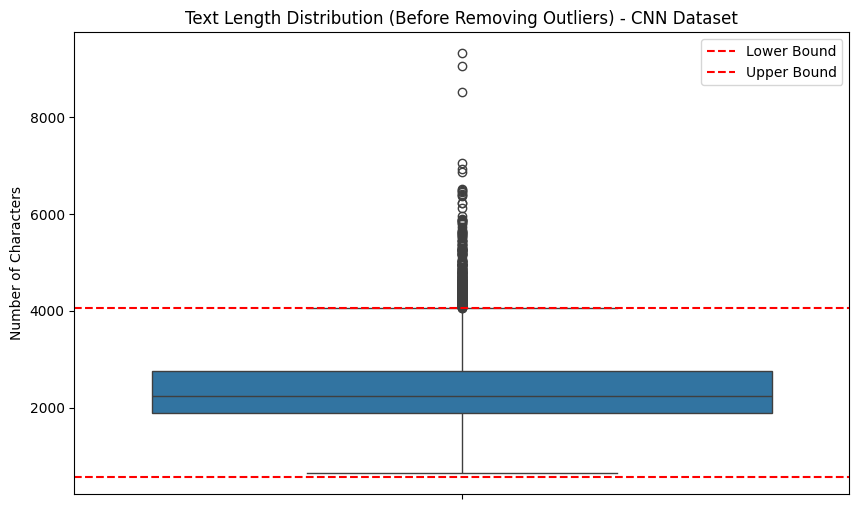

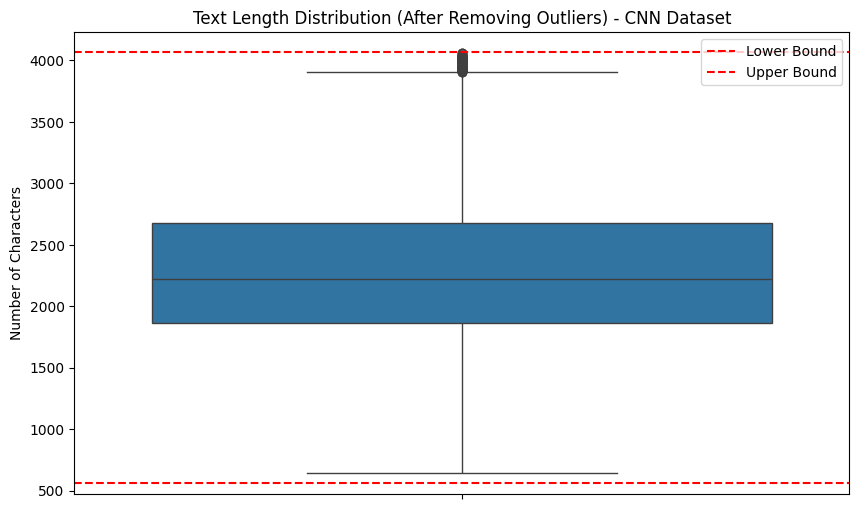

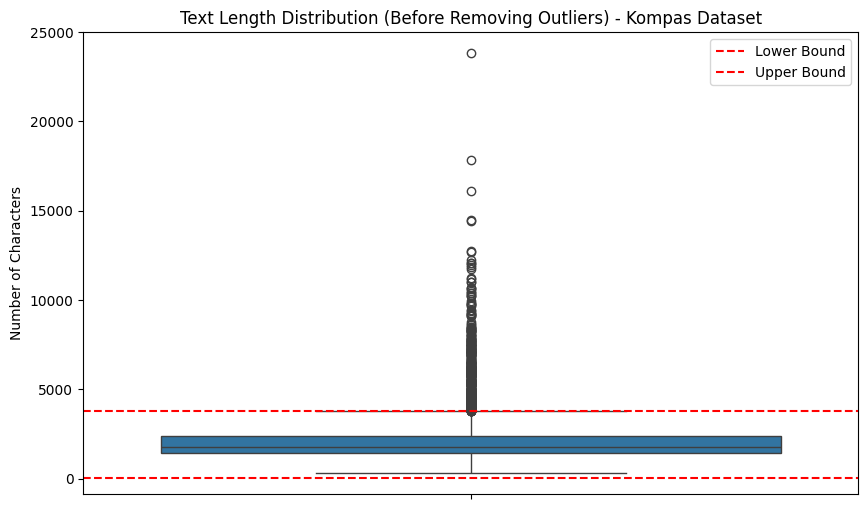

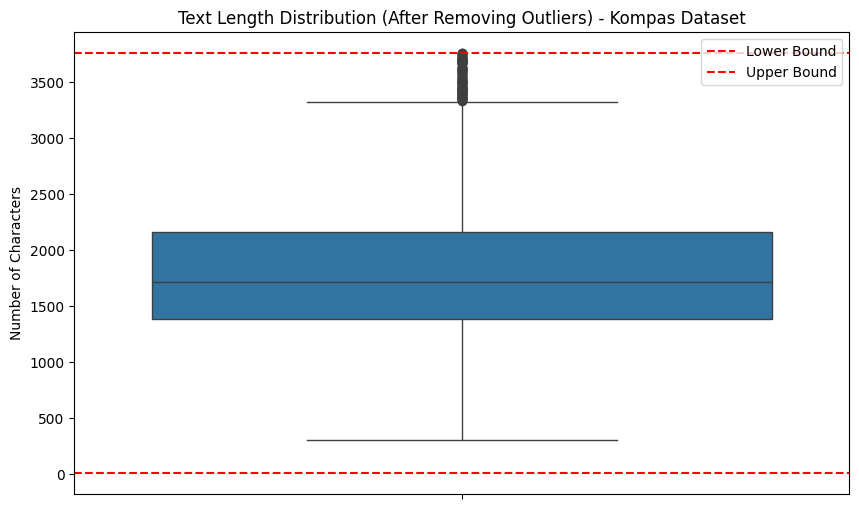

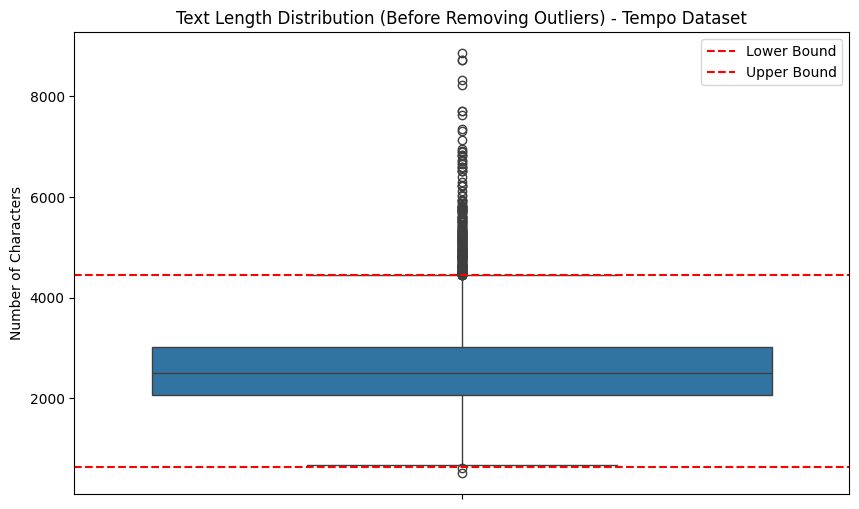

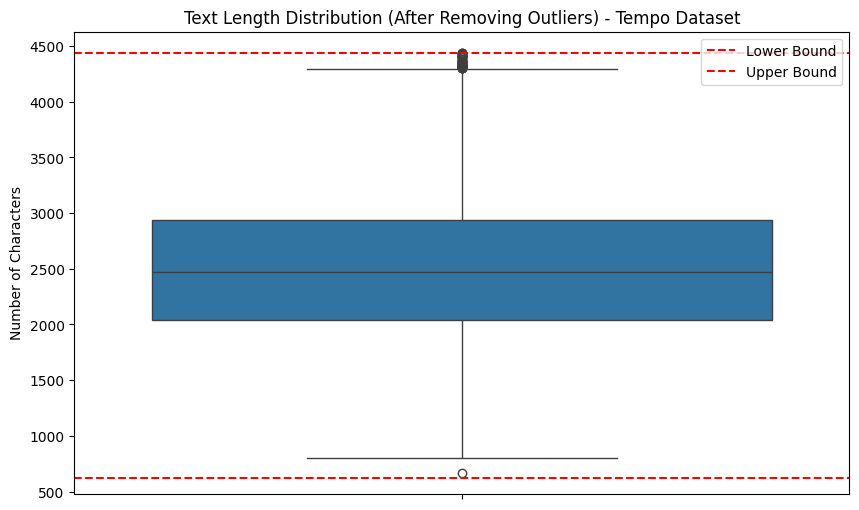

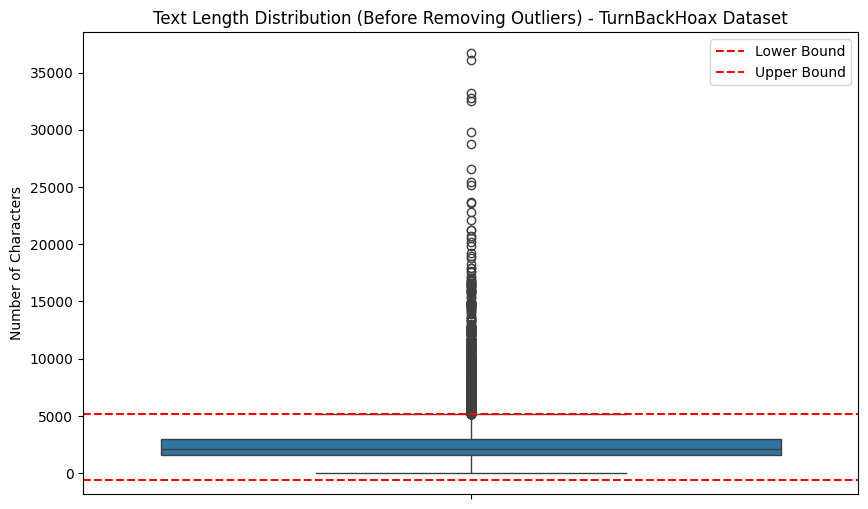

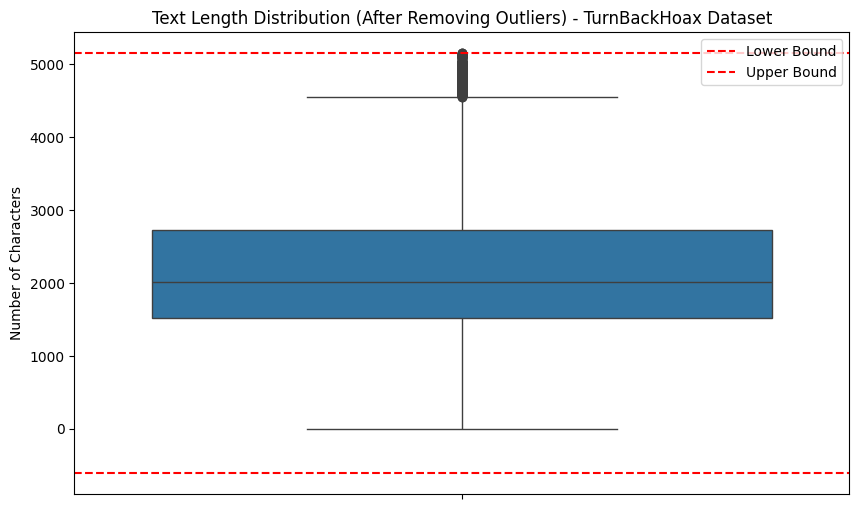

In [13]:
def remove_outliers_with_visualization(df, dataset_name):
    df['text_length'] = df['cleaned'].str.len()
    
    Q1 = df['text_length'].quantile(0.25)
    Q3 = df['text_length'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df['text_length'])
    plt.title(f'Text Length Distribution (Before Removing Outliers) - {dataset_name}')
    plt.ylabel('Number of Characters')
    plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
    plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound')
    plt.legend()
    plt.show()

    df_cleaned = df[(df['text_length'] >= lower_bound) & (df['text_length'] <= upper_bound)]

    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df_cleaned['text_length'])
    plt.title(f'Text Length Distribution (After Removing Outliers) - {dataset_name}')
    plt.ylabel('Number of Characters')
    plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
    plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound')
    plt.legend()
    plt.show()

    df_cleaned = df_cleaned.drop('text_length', axis=1)
    return df_cleaned

df_cnn_new = remove_outliers_with_visualization(df_cnn_new, "CNN Dataset")
df_kompas_new = remove_outliers_with_visualization(df_kompas_new, "Kompas Dataset")
df_tempo_new = remove_outliers_with_visualization(df_tempo_new, "Tempo Dataset")
df_tbh_new = remove_outliers_with_visualization(df_tbh_new, "TurnBackHoax Dataset")


In [14]:
stop_words = set(stopwords.words('indonesian'))

additional_stopwords = {
    'rt', 'ny', 'd', 'klo', 'kalo', 'amp', 'biar', 'bikin',
    'bilang', 'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 'si', 'tau', 'tdk', 'tuh',
    'utk', 'ya', 'jd', 'jgn', 'sdh', 'aja', 'n', 't', 'nyg', 'hehe', 'pen', 'u',
    'nan', 'loh', 'rt', '&amp', 'yah', 'media', 'sumber', 'social', 'sosial',
    'jakarta', 'indonesia', 'cnn', 'kompas', 'tempo', 'narasi', 'turnbackhoax', 
    'medan', 'bandung', 'surabaya', 'bogor', 'bali', 'makassar', 'palembang', 
    'jogja', 'yogyakarta', 'solo', 'semarang', 'malang', 'solo', 'sulawesi', 
    'kalimantan', 'sumatera', 'jawa', 'banten', 'ntt', 'ntb', 'bali', 'papua', 
    'maluku', 'riau', 'jambi', 'aceh', 'lampung', 'bengkulu', 'gorontalo', 
    'sulsel', 'sulut', 'sulteng', 'sultra', 'sulbar', 'maluku', 'malut', 
    'jabar', 'jateng', 'jatim', 'jatim', 'hasil', 'periksa', 'faktanya', 'fakta', 'co', 
    'com', 'gabriela', 'nauli', 'sinaga', 'universitas', 'utara'
}
stop_words.update(additional_stopwords)

def remove_stopwords(text):
    return ' '.join([word for word in word_tokenize(str(text).lower()) 
                    if word.lower() not in stop_words])

df_cnn_new['cleaned'] = df_cnn_new['cleaned'].apply(remove_stopwords)
df_kompas_new['cleaned'] = df_kompas_new['cleaned'].apply(remove_stopwords)
df_tempo_new['cleaned'] = df_tempo_new['cleaned'].apply(remove_stopwords)
df_tbh_new['cleaned'] = df_tbh_new['cleaned'].apply(remove_stopwords)

In [15]:
df_tbh_new['cleaned'] = df_tbh_new['cleaned'].str.replace('hasil periksa fakta', '', regex=False)

In [16]:
normalization_dict = {
    'yg': 'yang',
    'dgn': 'dengan', 
    'utk': 'untuk',
    'tdk': 'tidak',
    'krn': 'karena',
    'dr': 'dari',
    'dlm': 'dalam',
    'pd': 'pada',
    'jd': 'jadi',
    'hrs': 'harus',
    'sdh': 'sudah',
    'spy': 'supaya',
    'kpd': 'kepada',
    'thd': 'terhadap',
    'klo': 'kalau',
    'stlh': 'setelah',
    'sblm': 'sebelum',
    'sk': 'suka',
    'gk': 'tidak',
    'tp': 'tapi',
    'trs': 'terus',
    'bs': 'bisa',
    'aja': 'saja',
    'bgt': 'banget',
    'dmn': 'dimana',
    'gitu': 'begitu', 
    'gmn': 'bagaimana',
    'gada': 'tidak ada',
    'gua': 'saya',
    'gw': 'saya',
    'org': 'orang',
    'udh': 'sudah',
    'udah': 'sudah',
    'dah': 'sudah',
    'tuh': 'itu',
    'tau': 'tahu',
    'gapapa': 'tidak apa apa',
    'gaada': 'tidak ada',
    'emg': 'memang',
    'emang': 'memang',
    'kmrn': 'kemarin',
    'skrg': 'sekarang',
    'sm': 'sama',
    'spt': 'seperti',
    'biar': 'membiarkan',
    'bikin': 'membuat',
    'bilang': 'berkata',
    'brp': 'berapa',
    'byk': 'banyak',
    'bbrp': 'beberapa',
    'hrus': 'harus',
    'tgl': 'tanggal',
    'bln': 'bulan',
    'thn': 'tahun',
    'sgt': 'sangat',
    'pd': 'pada',
    'sy': 'saya',
    'dll': 'dan lain lain',
    'dsb': 'dan sebagainya',
    'dkk': 'dan kawan kawan',
    'ttg': 'tentang',
    'tsb': 'tersebut',
    'dll': 'dan lain lain',
    'sbg': 'sebagai',
    'sbl': 'sebelum',
    'stl': 'setelah',
    'msk': 'masuk',
    'mjd': 'menjadi',
    'pkl': 'pukul',
    'dgr': 'dengar',
    'cb': 'coba',
    'ktmu': 'ketemu',
    'ga': 'tidak',
    'gak': 'tidak',
    'gamau': 'tidak mau',
    'gabisa': 'tidak bisa',
    'gada': 'tidak ada',
    'gk': 'tidak',
    'goblok': 'bodoh',
    'goblog': 'bodoh',
    'id': 'indonesia',
    'republik': 'republik indonesia',
    'ri': 'republik indonesia',
    'dki': 'daerah khusus ibukota',
    'dpr': 'dewan perwakilan rakyat',
    'dprd': 'dewan perwakilan rakyat daerah',
    'pemda': 'pemerintah daerah',
    'pemkot': 'pemerintah kota',
    'pemprov': 'pemerintah provinsi',
    'kemenhub': 'kementerian perhubungan',
    'kemenkes': 'kementerian kesehatan',
    'kemendagri': 'kementerian dalam negeri',
    'kemenlu': 'kementerian luar negeri',
    'kemenag': 'kementerian agama',
    'kemensos': 'kementerian sosial',
    'wkwk': 'tertawa',
    'haha': 'tertawa',
    'wow': 'kagum',
    'huhu': 'sedih',
    'aduh': 'terkejut',
    'ckck': 'menggelengkan kepala'
}

def normalize_text(text):
    words = text.split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

df_cnn_new['cleaned'] = df_cnn_new['cleaned'].apply(normalize_text)
df_kompas_new['cleaned'] = df_kompas_new['cleaned'].apply(normalize_text)
df_tempo_new['cleaned'] = df_tempo_new['cleaned'].apply(normalize_text)
df_tbh_new['cleaned'] = df_tbh_new['cleaned'].apply(normalize_text)

df_cnn_new['cleaned'] = df_cnn_new['cleaned'].apply(lambda x: ' '.join(x.split()))
df_kompas_new['cleaned'] = df_kompas_new['cleaned'].apply(lambda x: ' '.join(x.split()))
df_tempo_new['cleaned'] = df_tempo_new['cleaned'].apply(lambda x: ' '.join(x.split()))
df_tbh_new['cleaned'] = df_tbh_new['cleaned'].apply(lambda x: ' '.join(x.split()))

# Label

Add Label 0 (True) to CNN, Kompas, and Tempo
| Add Label 1 (False) to TurnBackHoax

In [17]:
df_cnn_new.head()

,isi_berita,cleaned
0,"Jakarta, CNN Indonesia -- Mantan Gubernur DKI ...",mantan gubernur daerah khusus ibukota anies ba...
1,"Medan, CNN Indonesia -- Gubernur Sumatera Utar...",gubernur edy rahmayadi membuka maju pilkada 20...
2,"Jakarta, CNN Indonesia -- Partai Kebangkitan B...",partai kebangkitan bangsa pkb mengusung menter...
3,"Jakarta, CNN Indonesia -- Ketua Umum Partai Ke...",ketua partai kebangkitan nusantara pkn i gede ...
4,"Jakarta, CNN Indonesia -- Dewan Pimpinan Pusat...",dewan pimpinan pusat dpp partai kebangkitan nu...


In [18]:
df_kompas_new.head()

,isi_berita,cleaned
0,Hasil jajak pendapat yang diselenggarakan Litb...,jajak pendapat diselenggarakan litbang 25 janu...
1,"JAKARTA, KOMPAS.com - Pemerintah menargetkan p...",pemerintah menargetkan pertumbuhan ekonomi 202...
2,"PDI-Perjuangan, Partai Gerindra, dan Partai Go...",pdi perjuangan partai gerindra partai golkar m...
3,"JAKARTA, KOMPAS.com - Survei Litbang Kompas Ja...",survei litbang januari 2023 partai golkar pdi ...
5,Sejumlah Ketua Umum Partai dan tokoh politik p...,ketua partai tokoh politik merasakan duduk mak...


In [19]:
df_tempo_new.head()

,isi_berita,cleaned
0,"TEMPO.CO, Jakarta - Wakil Presiden Ma'ruf Amin...",wakil presiden ma ruf amin dijadwalkan menyaks...
1,"TEMPO.CO, Jakarta - Menteri Agama Yaqut Cholil...",menteri agama yaqut cholil qoumas masyarakat m...
2,"TEMPO.CO, Jakarta - Presiden Joko Widodo atau ...",presiden joko widodo jokowi mengajak menyongso...
4,"TEMPO.CO, Jakarta - Menteri Pendayagunaan Apar...",menteri pendayagunaan aparatur negara reformas...
5,"TEMPO.CO, Jakarta - Tenaga Ahli Utama Kantor S...",tenaga ahli utama kantor staf presiden ksp abr...


In [20]:
df_tbh_new.head()

,isi_berita,cleaned
0,Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,komunitas alpha omega menyambut anies baswedan...
1,Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,isu terkait kecelakaan tunggal dialami hakim w...
2,Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,gambar diedit foto aslinya unggahan akun insta...
3,Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,jonathan latumahina mualaf dibuktikan unggahan...
4,Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,bmkg memiliki tupoksi kerja gempa vulkanik ter...


In [21]:
df_cnn_new['label'] = 0    # Fakta
df_kompas_new['label'] = 0 # Fakta
df_tempo_new['label'] = 0  # Fakta 
df_tbh_new['label'] = 1    # Hoax

df_clean_all = pd.concat([df_cnn_new, df_kompas_new, df_tempo_new, df_tbh_new])

In [22]:
df_clean_all

,isi_berita,cleaned,label
0,"Jakarta, CNN Indonesia -- Mantan Gubernur DKI ...",mantan gubernur daerah khusus ibukota anies ba...,0
1,"Medan, CNN Indonesia -- Gubernur Sumatera Utar...",gubernur edy rahmayadi membuka maju pilkada 20...,0
2,"Jakarta, CNN Indonesia -- Partai Kebangkitan B...",partai kebangkitan bangsa pkb mengusung menter...,0
3,"Jakarta, CNN Indonesia -- Ketua Umum Partai Ke...",ketua partai kebangkitan nusantara pkn i gede ...,0
4,"Jakarta, CNN Indonesia -- Dewan Pimpinan Pusat...",dewan pimpinan pusat dpp partai kebangkitan nu...,0
...,...,...,...
10379,Sumber : media sosial\nNarasi : Raja Salman da...,raja salman arab saudi membawa orang orang men...,1
10380,"Sumber : media sosial\nNarasi : hehe, selalu b...",tersenyum tingkah laku jokowi terimakasih meng...,1
10381,Sumber : Media Sosial\nNarasi : Pak Jokowi itu...,jokowi walikota periode salah 2005 s 2010 mari...,1
10382,"Sumber : media sosial\nNarasi : Hari ini, Rabu...",rabu 23 09 2015 nilai tukar rupiah terpuruk me...,1


<Figure size 1000x600 with 0 Axes>

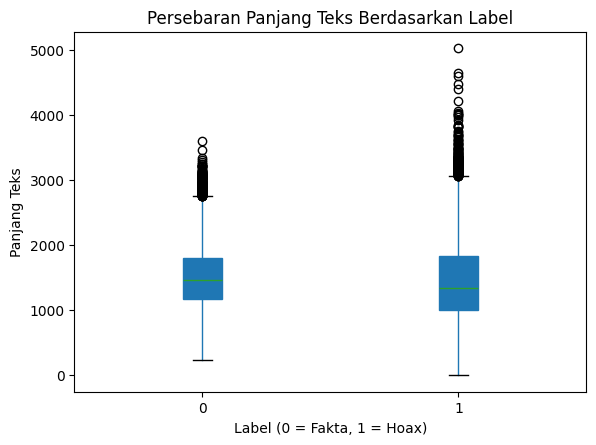

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

df_clean_all['text_length'] = df_clean_all['cleaned'].apply(len)

plt.figure(figsize=(10, 6))
df_clean_all.boxplot(column='text_length', by='label', grid=False, patch_artist=True)

plt.title('Persebaran Panjang Teks Berdasarkan Label')
plt.suptitle('')
plt.xlabel('Label (0 = Fakta, 1 = Hoax)')
plt.ylabel('Panjang Teks')
plt.show()

/tmp/ipykernel_1426/1789439301.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


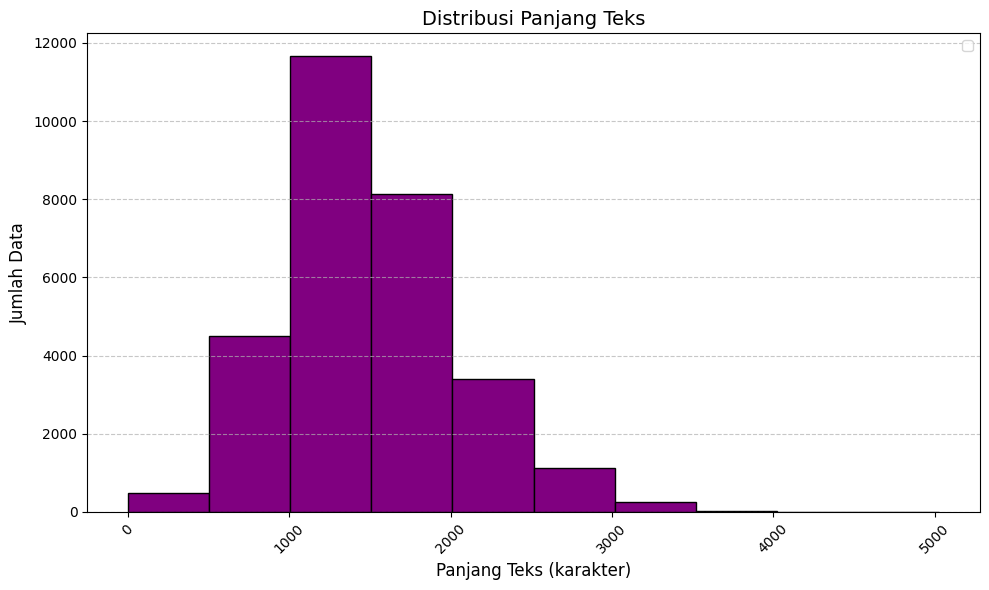

In [24]:
import matplotlib.pyplot as plt

text_lengths = df_clean_all['text_length']

plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=10, edgecolor='black', color='purple')

plt.title('Distribusi Panjang Teks', fontsize=14)
plt.xlabel('Panjang Teks (karakter)', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()  
plt.tight_layout()

plt.show()


In [25]:
df_clean_all

,isi_berita,cleaned,label,text_length
0,"Jakarta, CNN Indonesia -- Mantan Gubernur DKI ...",mantan gubernur daerah khusus ibukota anies ba...,0,1343
1,"Medan, CNN Indonesia -- Gubernur Sumatera Utar...",gubernur edy rahmayadi membuka maju pilkada 20...,0,1012
2,"Jakarta, CNN Indonesia -- Partai Kebangkitan B...",partai kebangkitan bangsa pkb mengusung menter...,0,1070
3,"Jakarta, CNN Indonesia -- Ketua Umum Partai Ke...",ketua partai kebangkitan nusantara pkn i gede ...,0,950
4,"Jakarta, CNN Indonesia -- Dewan Pimpinan Pusat...",dewan pimpinan pusat dpp partai kebangkitan nu...,0,1024
...,...,...,...,...
10379,Sumber : media sosial\nNarasi : Raja Salman da...,raja salman arab saudi membawa orang orang men...,1,256
10380,"Sumber : media sosial\nNarasi : hehe, selalu b...",tersenyum tingkah laku jokowi terimakasih meng...,1,154
10381,Sumber : Media Sosial\nNarasi : Pak Jokowi itu...,jokowi walikota periode salah 2005 s 2010 mari...,1,426
10382,"Sumber : media sosial\nNarasi : Hari ini, Rabu...",rabu 23 09 2015 nilai tukar rupiah terpuruk me...,1,133


# ============================================

In [26]:
df_after_clean = df_clean_all
df_after_clean.drop(['text_length', 'isi_berita'], axis=1, inplace=True)
# df_after_clean = df_after_clean.rename(columns={'cleaned_lower': 'cleaned_text'})

In [27]:
df_after_clean

,cleaned,label
0,mantan gubernur daerah khusus ibukota anies ba...,0
1,gubernur edy rahmayadi membuka maju pilkada 20...,0
2,partai kebangkitan bangsa pkb mengusung menter...,0
3,ketua partai kebangkitan nusantara pkn i gede ...,0
4,dewan pimpinan pusat dpp partai kebangkitan nu...,0
...,...,...
10379,raja salman arab saudi membawa orang orang men...,1
10380,tersenyum tingkah laku jokowi terimakasih meng...,1
10381,jokowi walikota periode salah 2005 s 2010 mari...,1
10382,rabu 23 09 2015 nilai tukar rupiah terpuruk me...,1


In [28]:
# from imblearn.under_sampling import RandomUnderSampler

X = df_after_clean[['cleaned']]
y = df_after_clean['label']

# rus = RandomUnderSampler(random_state=1, replacement=True)
# X_new, y_new = rus.fit_resample(X,y)

In [29]:
X

,cleaned
0,mantan gubernur daerah khusus ibukota anies ba...
1,gubernur edy rahmayadi membuka maju pilkada 20...
2,partai kebangkitan bangsa pkb mengusung menter...
3,ketua partai kebangkitan nusantara pkn i gede ...
4,dewan pimpinan pusat dpp partai kebangkitan nu...
...,...
10379,raja salman arab saudi membawa orang orang men...
10380,tersenyum tingkah laku jokowi terimakasih meng...
10381,jokowi walikota periode salah 2005 s 2010 mari...
10382,rabu 23 09 2015 nilai tukar rupiah terpuruk me...


In [30]:
y

0        0
1        0
2        0
3        0
4        0
        ..
10379    1
10380    1
10381    1
10382    1
10383    1
Name: label, Length: 29610, dtype: int64

In [31]:
from collections import Counter

counter = Counter(y)
print(counter)

Counter({0: 19975, 1: 9635})


In [32]:
df_clean_new = X
df_clean_new['label'] = y

In [33]:
df_clean_new

,cleaned,label
0,mantan gubernur daerah khusus ibukota anies ba...,0
1,gubernur edy rahmayadi membuka maju pilkada 20...,0
2,partai kebangkitan bangsa pkb mengusung menter...,0
3,ketua partai kebangkitan nusantara pkn i gede ...,0
4,dewan pimpinan pusat dpp partai kebangkitan nu...,0
...,...,...
10379,raja salman arab saudi membawa orang orang men...,1
10380,tersenyum tingkah laku jokowi terimakasih meng...,1
10381,jokowi walikota periode salah 2005 s 2010 mari...,1
10382,rabu 23 09 2015 nilai tukar rupiah terpuruk me...,1


In [34]:
df_true = df_clean_new[df_clean_new['label'] == 0]

df_true

,cleaned,label
0,mantan gubernur daerah khusus ibukota anies ba...,0
1,gubernur edy rahmayadi membuka maju pilkada 20...,0
2,partai kebangkitan bangsa pkb mengusung menter...,0
3,ketua partai kebangkitan nusantara pkn i gede ...,0
4,dewan pimpinan pusat dpp partai kebangkitan nu...,0
...,...,...
6587,wakil ketua dewan perwakilan rakyat republik i...,0
6588,ketua dpp partai nasdem willy aditya menanggap...,0
6589,berita menarik perhatian pembaca pagi ketua dp...,0
6590,ketua dpp partai nasdem sugeng suparwoto penda...,0


In [35]:
df_false = df_clean_new[df_clean_new['label'] == 1]

df_false

,cleaned,label
0,komunitas alpha omega menyambut anies baswedan...,1
1,isu terkait kecelakaan tunggal dialami hakim w...,1
2,gambar diedit foto aslinya unggahan akun insta...,1
3,jonathan latumahina mualaf dibuktikan unggahan...,1
4,bmkg memiliki tupoksi kerja gempa vulkanik ter...,1
...,...,...
10379,raja salman arab saudi membawa orang orang men...,1
10380,tersenyum tingkah laku jokowi terimakasih meng...,1
10381,jokowi walikota periode salah 2005 s 2010 mari...,1
10382,rabu 23 09 2015 nilai tukar rupiah terpuruk me...,1


In [36]:
dataset_train_test_true = Dataset.from_pandas(df_true).train_test_split(seed=1, test_size=0.2)

dataset_train_test_false = Dataset.from_pandas(df_false).train_test_split(seed=1, test_size=0.2)

In [37]:
dataset_test_eval_true = dataset_train_test_true['test'].train_test_split(seed=1, test_size=0.5)

dataset_test_eval_false = dataset_train_test_false['test'].train_test_split(seed=1, test_size=0.5)

In [38]:
ds_train = concatenate_datasets([
    dataset_train_test_true['train'], 
    dataset_train_test_false['train']
])
ds_eval = concatenate_datasets([
    dataset_test_eval_true['train'], 
    dataset_test_eval_false['train'] 
])
ds_test = concatenate_datasets([
    dataset_test_eval_true['test'], 
    dataset_test_eval_false['test'] 
])

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# IndoBERT

In [40]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1") #mengkonversi ke dalam bentuk pemahaman model
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)

pytorch_model.bin:  29%|##9       | 147M/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Tokenize

In [41]:
def tokenize_dataset(data):
    # Keys of the returned dictionary will be added to the dataset as columns
    return tokenizer(data["cleaned"], padding=True, truncation=True, max_length=512)

ds_train_ = ds_train.map(tokenize_dataset)
ds_eval_ = ds_eval.map(tokenize_dataset)
ds_test_ = ds_test.map(tokenize_dataset)

Map:   0%|          | 0/23688 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Map:   0%|          | 0/2960 [00:00<?, ? examples/s]

Map:   0%|          | 0/2962 [00:00<?, ? examples/s]

In [42]:
ds_train_tokenized = ds_train_.remove_columns(["cleaned"])
ds_eval_tokenized = ds_eval_.remove_columns(["cleaned"])
ds_test_tokenized = ds_test_.remove_columns(["cleaned"])

dataset_full = DatasetDict({
    'train': ds_train_tokenized,
    'test': ds_test_tokenized,
    'eval': ds_eval_tokenized})

dataset_full

DatasetDict({
    train: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 23688
    })
    test: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2962
    })
    eval: Dataset({
        features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2960
    })
})

# Training

In [ ]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from transformers import Trainer, TrainingArguments

# Parameter yang akan diuji
learning_rates = [1e-5, 2e-5, 3e-5]  # 3 pilihan Learning Rate
batch_sizes = [16]  # Hanya 1 batch size
num_train_epochs = 5  # Tetap
weight_decay = 0.01  # Tetap

# Semua kombinasi parameter yang akan diuji (tanpa pengulangan)
param_combinations = list(itertools.product(learning_rates, batch_sizes))

# Simpan hasil dalam DataFrame untuk visualisasi
results = []
best_score = 0
best_params = None

print("\n==== Grid Search ====\n")

for i, (learning_rate, batch_size) in enumerate(param_combinations):
    print(f"\nTraining model dengan parameter ke-{i+1}:")
    print(f"  Learning Rate   : {learning_rate}")
    print(f"  Batch Size      : {batch_size}")
    print(f"  Weight Decay    : {weight_decay}")
    print(f"  Epochs          : {num_train_epochs}")

    # Definisi TrainingArguments
    args = TrainingArguments(
        output_dir="temp_output",
        evaluation_strategy="epoch",
        save_strategy="no",  # Tidak menyimpan model
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        logging_dir="./logs",
        logging_steps=100
    )

    # Inisialisasi Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=dataset_full["train"],
        eval_dataset=dataset_full["eval"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Training
    os.environ["WANDB_DISABLED"] = "true"
    trainer.train()

    # Evaluasi setelah training selesai
    eval_results = trainer.evaluate(eval_dataset=dataset_full["test"])
    score = eval_results["eval_accuracy"]

    print(f"  Accuracy: {score:.4f}")

    # Simpan hasil ke list untuk visualisasi
    results.append({
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "num_train_epochs": num_train_epochs,
        "accuracy": score
    })

    # Simpan parameter terbaik
    if score > best_score:
        best_score = score
        best_params = (learning_rate, batch_size)

print("\n==== Best Parameters ====\n")
print(f"  Learning Rate   : {best_params[0]}")
print(f"  Batch Size      : {best_params[1]}")
print(f"  Weight Decay    : {weight_decay}")
print(f"  Epochs          : {num_train_epochs}")
print(f"  Best Accuracy   : {best_score:.4f}")

# Konversi hasil ke DataFrame untuk visualisasi
results_df = pd.DataFrame(results)

# ============== Visualisasi Hasil ==============

# 1. Plot Akurasi vs Learning Rate
plt.figure(figsize=(10, 6))
sns.boxplot(x="learning_rate", y="accuracy", data=results_df)
plt.title("Akurasi Berdasarkan Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.show()

# 2. Heatmap untuk melihat pengaruh Learning Rate terhadap akurasi
pivot_table = results_df.pivot_table(index="learning_rate", values="accuracy", aggfunc="mean")

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Heatmap Akurasi Berdasarkan Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.show()


==== Grid Search ====


Training model dengan parameter ke-1:
  Learning Rate   : 1e-05
  Batch Size      : 16
  Weight Decay    : 0.01
  Epochs          : 5


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_1426/1183108776.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.004300,0.010332,0.997635,0.997636,0.997635,0.997635
2,0.000500,0.013508,0.997973,0.997973,0.997973,0.997973
3,0.001900,0.014560,0.997635,0.997636,0.997635,0.997635
4,0.000000,0.016543,0.997635,0.997636,0.997635,0.997635
5,0.000000,0.014464,0.998311,0.998311,0.998311,0.998311


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


  Accuracy: 0.9983

Training model dengan parameter ke-2:
  Learning Rate   : 2e-05
  Batch Size      : 16
  Weight Decay    : 0.01
  Epochs          : 5


/tmp/ipykernel_1426/1183108776.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.005000,0.034571,0.995270,0.995322,0.995270,0.995278
2,0.004700,0.009413,0.998649,0.998650,0.998649,0.998649
3,0.000000,0.010388,0.998649,0.998649,0.998649,0.998649
4,0.000000,0.009420,0.998649,0.998650,0.998649,0.998649
5,0.002100,0.009233,0.998649,0.998649,0.998649,0.998649


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


  Accuracy: 0.9986

Training model dengan parameter ke-3:
  Learning Rate   : 3e-05
  Batch Size      : 16
  Weight Decay    : 0.01
  Epochs          : 5


/tmp/ipykernel_1426/1183108776.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,0.021156,0.998311,0.998314,0.998311,0.998311
2,0.000000,0.019421,0.998311,0.998314,0.998311,0.998311
3,0.000000,0.019131,0.998649,0.998649,0.998649,0.998649
4,0.000000,0.019242,0.998311,0.998312,0.998311,0.998311
5,0.000000,0.019027,0.998311,0.998312,0.998311,0.998311


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

  Accuracy: 0.9986

==== Best Parameters ====

  Learning Rate   : 2e-05
  Batch Size      : 16
  Weight Decay    : 0.01
  Epochs          : 5
  Best Accuracy   : 0.9986

Hasil grid search telah disimpan ke 'grid_search_results.csv'.
Spearman Correlation Coefficient: 0.8660


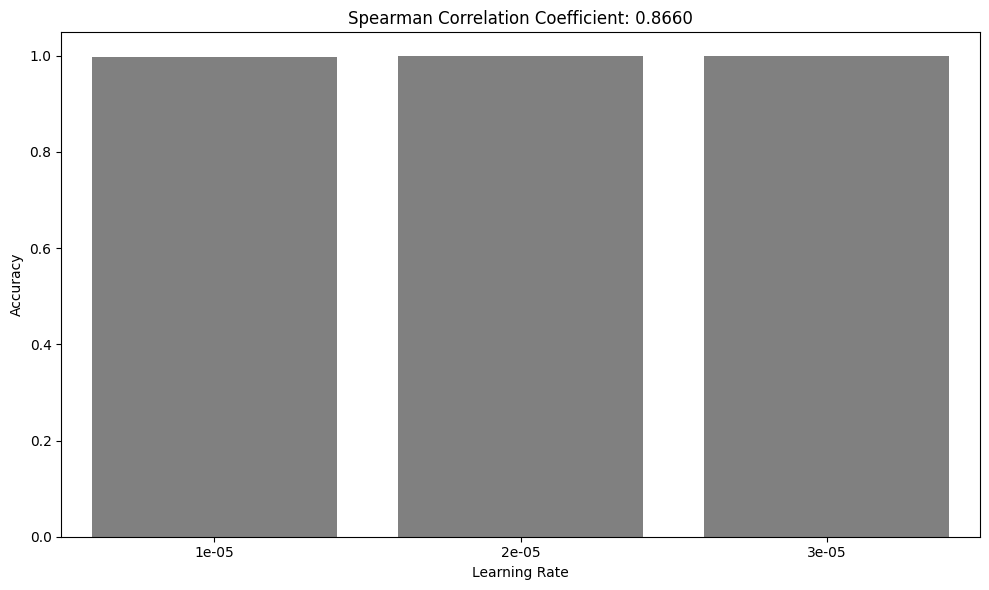

Plot Spearman Correlation telah disimpan ke 'spearman_correlation_plot.png'.


In [44]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr
from transformers import Trainer, TrainingArguments

# Parameter yang akan diuji
learning_rates = [1e-5, 2e-5, 3e-5]  # 3 pilihan Learning Rate
batch_sizes = [16]  # Hanya 1 batch size
num_train_epochs = 5  # Tetap
weight_decay = 0.01  # Tetap

# Semua kombinasi parameter yang akan diuji (tanpa pengulangan)
param_combinations = list(itertools.product(learning_rates, batch_sizes))

# Simpan hasil dalam DataFrame untuk visualisasi
results = []
best_score = 0
best_params = None

print("\n==== Grid Search ====\n")

for i, (learning_rate, batch_size) in enumerate(param_combinations):
    print(f"\nTraining model dengan parameter ke-{i+1}:")
    print(f"  Learning Rate   : {learning_rate}")
    print(f"  Batch Size      : {batch_size}")
    print(f"  Weight Decay    : {weight_decay}")
    print(f"  Epochs          : {num_train_epochs}")

    # Definisi TrainingArguments
    args = TrainingArguments(
        output_dir="temp_output",
        evaluation_strategy="epoch",
        save_strategy="no",  # Tidak menyimpan model
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        logging_dir="./logs",
        logging_steps=100
    )

    # Inisialisasi Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=dataset_full["train"],
        eval_dataset=dataset_full["eval"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Training
    os.environ["WANDB_DISABLED"] = "true"
    trainer.train()

    # Evaluasi setelah training selesai
    eval_results = trainer.evaluate(eval_dataset=dataset_full["test"])
    score = eval_results["eval_accuracy"]

    print(f"  Accuracy: {score:.4f}")

    # Simpan hasil ke list untuk visualisasi
    results.append({
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "num_train_epochs": num_train_epochs,
        "accuracy": score
    })

    # Simpan parameter terbaik
    if score > best_score:
        best_score = score
        best_params = (learning_rate, batch_size)

print("\n==== Best Parameters ====\n")
print(f"  Learning Rate   : {best_params[0]}")
print(f"  Batch Size      : {best_params[1]}")
print(f"  Weight Decay    : {weight_decay}")
print(f"  Epochs          : {num_train_epochs}")
print(f"  Best Accuracy   : {best_score:.4f}")

# Konversi hasil ke DataFrame
results_df = pd.DataFrame(results)

# Simpan hasil ke file CSV
results_df.to_csv("grid_search_results.csv", index=False)
print("\nHasil grid search telah disimpan ke 'grid_search_results.csv'.")

# ======== Visualisasi Spearman Correlation Coefficient ========
# Hitung Spearman correlation coefficient
correlation, p_value = spearmanr(results_df["learning_rate"], results_df["accuracy"])
print(f"Spearman Correlation Coefficient: {correlation:.4f}")

# Plot hasil spearman correlation
plt.figure(figsize=(10, 6))
sns.barplot(x="learning_rate", y="accuracy", data=results_df, color="gray")
plt.title("Spearman Correlation Coefficient: {:.4f}".format(correlation))
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig("spearman_correlation_plot.png")
plt.show()

print("Plot Spearman Correlation telah disimpan ke 'spearman_correlation_plot.png'.")

   learning_rate  batch_size  weight_decay  num_train_epochs  accuracy
0        0.00001          16          0.01                 5  0.998312
1        0.00002          16          0.01                 5  0.998650
2        0.00003          16          0.01                 5  0.998650
Spearman Correlation Coefficient: 0.8660


/tmp/ipykernel_1426/1993748891.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


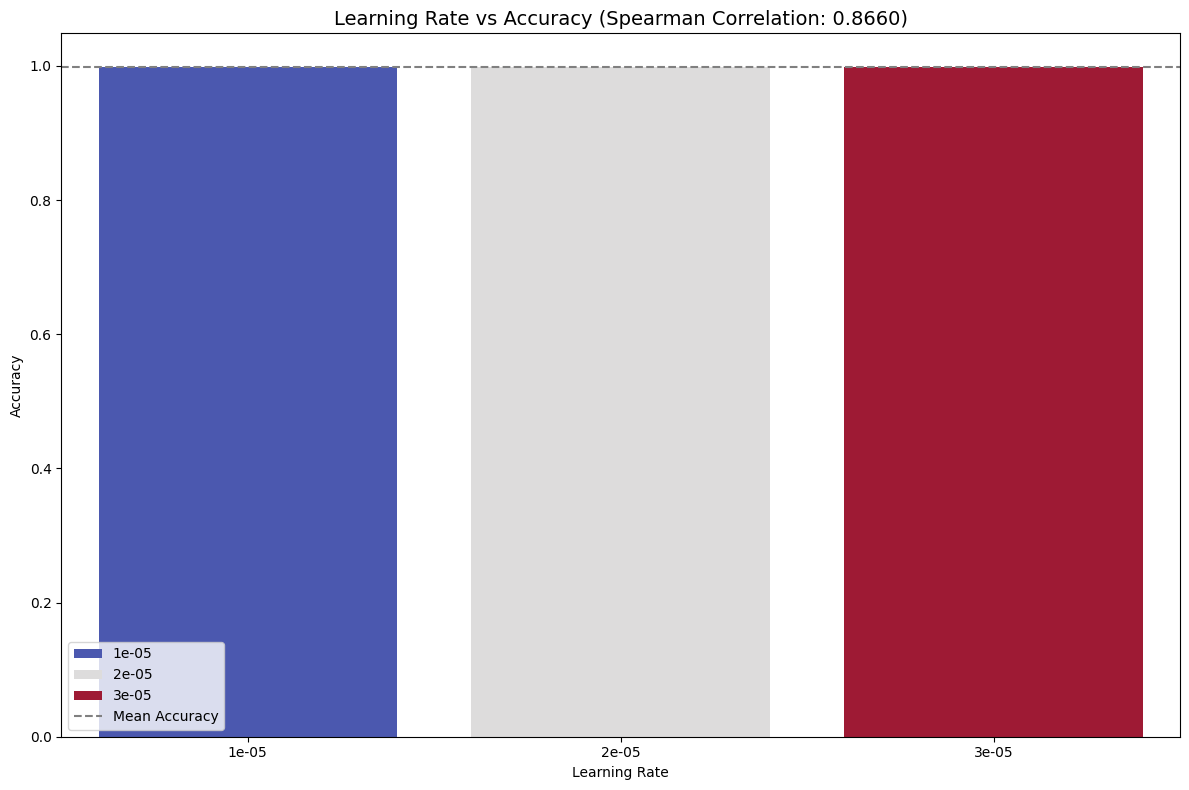

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Membaca hasil training dari file CSV
file_name = "grid_search_results.csv"
results_df = pd.read_csv(file_name)

# Cek data
print(results_df.head())

# Pastikan kolom yang diperlukan ada
assert "learning_rate" in results_df.columns, "Kolom 'learning_rate' tidak ditemukan"
assert "accuracy" in results_df.columns, "Kolom 'accuracy' tidak ditemukan"

# Spearman Correlation Coefficient
spearman_corr, _ = spearmanr(results_df["learning_rate"], results_df["accuracy"])
print(f"Spearman Correlation Coefficient: {spearman_corr:.4f}")

# Membuat visualisasi
plt.figure(figsize=(12, 8))

# Grouping data berdasarkan learning_rate
sns.barplot(
    data=results_df,
    x="learning_rate",
    y="accuracy",
    ci="sd",
    hue="learning_rate",  # Pewarnaan berdasarkan learning rate
    palette="coolwarm",
)

# Menambahkan garis Spearman Correlation
plt.axhline(y=results_df["accuracy"].mean(), color="gray", linestyle="--", label="Mean Accuracy")

# Menambahkan informasi Spearman Correlation
plt.title(f"Learning Rate vs Accuracy (Spearman Correlation: {spearman_corr:.4f})", fontsize=14)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

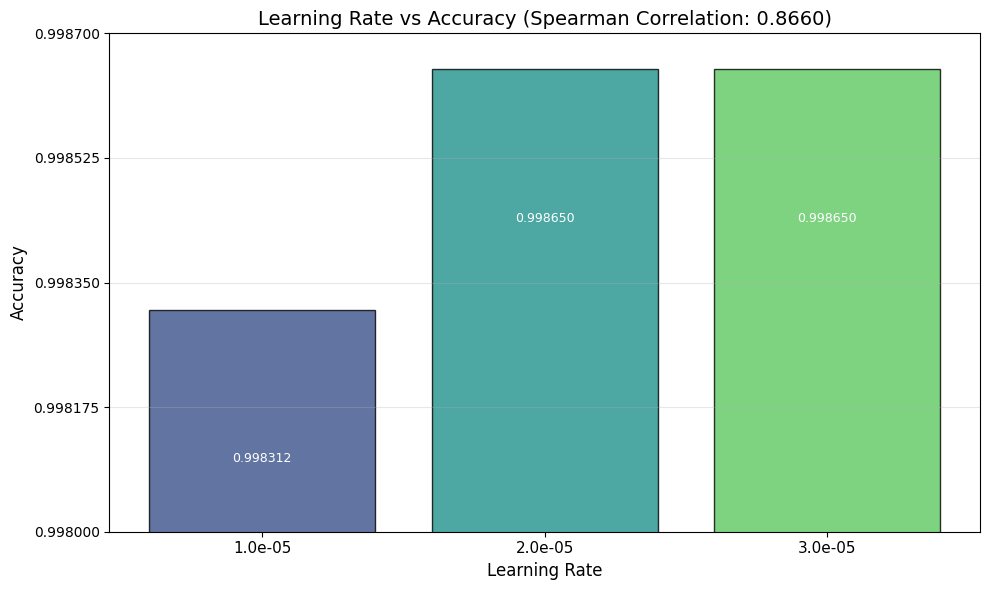

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Data contoh dari pengguna
data = {
    "learning_rate": [1e-5, 2e-5, 3e-5],
    "accuracy": [0.9983119513841998, 0.9986495611073599, 0.9986495611073599]
}
results_df = pd.DataFrame(data)

# Menghitung Spearman Correlation
spearman_corr, _ = spearmanr(results_df["learning_rate"], results_df["accuracy"])

# Format learning rate ke notasi ilmiah
results_df["learning_rate_str"] = results_df["learning_rate"].apply(lambda x: f"{x:.1e}")

# Membuat plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    results_df["learning_rate_str"],
    results_df["accuracy"],
    color=sns.color_palette("viridis", 3),
    alpha=0.8,
    edgecolor="black"
)

# Atur skala sumbu Y untuk memperbesar perbedaan
plt.ylim(0.998, 0.9987)  # Fokus pada rentang sempit
plt.grid(axis="y", alpha=0.3)

# Annotasi nilai akurasi
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height - 0.0002,  # Posisi teks di dalam bar
        f"{height:.6f}",  # Tampilkan 6 desimal
        ha="center",
        va="top",
        fontsize=9,
        color="white"
    )

# Judul dan label
plt.title(f"Learning Rate vs Accuracy (Spearman Correlation: {spearman_corr:.4f})", fontsize=14)
plt.xlabel("Learning Rate", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(np.linspace(0.998, 0.9987, 5), fontsize=10)  # Ticks presisi tinggi

plt.tight_layout()
plt.show()

In [45]:
batch_size = 16

args = TrainingArguments(
    output_dir=f"IndoBERT-NotSummarized-HoaxDetection",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [43]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from evaluate import load
import numpy as np

metric = load("accuracy")

def compute_metrics(eval_pred, val_eval_pred=None):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    
    val_accuracy = None
    if val_eval_pred is not None:
        val_predictions, val_labels = val_eval_pred
        val_predictions = np.argmax(val_predictions, axis=1)
        val_accuracy = accuracy_score(val_labels, val_predictions)
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    if val_accuracy is not None:
        metrics['val_accuracy'] = val_accuracy
    
    return metrics

In [47]:
model = model.to(device)

trainer = Trainer(
    model,
    args,
    train_dataset=dataset_full["train"],
    eval_dataset=dataset_full["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

/tmp/ipykernel_1731/752296921.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [48]:
# before training
os.environ["WANDB_DISABLED"] = "true"
trainer.evaluate(eval_dataset=dataset_full["test"])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.6869174838066101,
 'eval_accuracy': 0.5493243243243243,
 'eval_precision': 0.5828550887929295,
 'eval_recall': 0.5493243243243243,
 'eval_f1': 0.5611709405037041,
 'eval_runtime': 21.3372,
 'eval_samples_per_second': 138.725,
 'eval_steps_per_second': 4.359}

In [49]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.035300,0.010298,0.997299,0.997313,0.997299,0.997301
2,0.006500,0.012811,0.996962,0.996972,0.996962,0.996964
3,0.000500,0.011625,0.997637,0.997646,0.997637,0.997638
4,0.001200,0.013014,0.997974,0.997976,0.997974,0.997975
5,0.000000,0.013168,0.997974,0.997976,0.997974,0.997975


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=3705, training_loss=0.006238576928662656, metrics={'train_runtime': 2099.6977, 'train_samples_per_second': 56.408, 'train_steps_per_second': 1.765, 'total_flos': 2.81673334760136e+16, 'train_loss': 0.006238576928662656, 'epoch': 5.0})

In [50]:
# after training
trainer.evaluate(eval_dataset=dataset_full["test"])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.009029868058860302,
 'eval_accuracy': 0.9986486486486487,
 'eval_precision': 0.9986486486486487,
 'eval_recall': 0.9986486486486487,
 'eval_f1': 0.9986486486486487,
 'eval_runtime': 20.8192,
 'eval_samples_per_second': 142.176,
 'eval_steps_per_second': 4.467,
 'epoch': 5.0}

In [52]:
pred_output = trainer.predict(test_dataset=dataset_full["test"])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [53]:
pred_output.metrics

{'test_loss': 0.009029868058860302,
 'test_accuracy': 0.9986486486486487,
 'test_precision': 0.9986486486486487,
 'test_recall': 0.9986486486486487,
 'test_f1': 0.9986486486486487,
 'test_runtime': 20.8468,
 'test_samples_per_second': 141.988,
 'test_steps_per_second': 4.461}

In [54]:
pred_label = np.argmax(pred_output.predictions, axis=1)
gt_label = dataset_full["test"]['label']

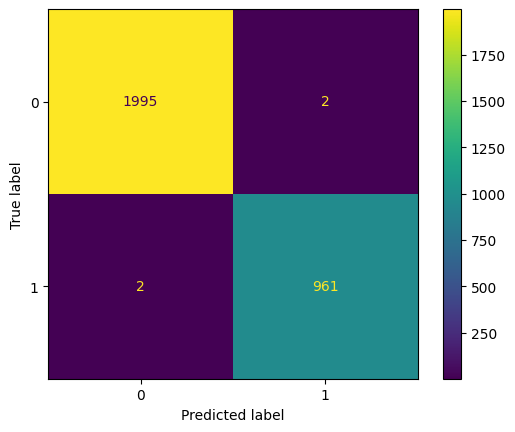

In [55]:
ConfusionMatrixDisplay.from_predictions(pred_label, gt_label);

In [56]:
test_data = tokenizer.batch_decode(dataset_full["test"]['input_ids'], skip_special_tokens=True)

pred_compare = []
for i, news in enumerate(test_data):
    pred_compare.append([news, gt_label[i], pred_label[i]])

df_pred_compare = pd.DataFrame(pred_compare)
df_pred_compare = df_pred_compare.rename(columns={0:'news', 1:'label', 2:'prediction'})
df_pred_compare.to_csv('predictions.csv')
df_pred_compare

,news,label,prediction
0,anggota dewan perwakilan rakyat komisi viii fr...,0,0
1,ketua badan pengawas pemilu bawaslu rahmat bag...,0,0
2,survei spektrum politika institute spi tingkat...,0,0
3,sekretaris jenderal sekjen pdip hasto kristiya...,0,0
4,forum transparansi anggaran fitra presiden jok...,0,0
...,...,...,...
2955,novita kusuma wardhani informasi salah melansi...,1,1
2956,ari dwi prasetyo sesuai judul artikel isi arti...,1,1
2957,rizky abdul aziz anggota komisariat mafindo pe...,1,1
2958,ani r informasi palsu kementerian agraria tata...,1,1


In [57]:
import random

num_samples = 100

random_indices = random.sample(range(len(test_data)), num_samples)
random_test_data = [test_data[i] for i in random_indices]
random_gt_label = [gt_label[i] for i in random_indices]
random_pred_label = [pred_label[i] for i in random_indices]

pred_compare_random = []
for i, news in enumerate(random_test_data):
    pred_compare_random.append([news, random_gt_label[i], random_pred_label[i]])

df_pred_compare_random = pd.DataFrame(pred_compare_random)
df_pred_compare_random = df_pred_compare_random.rename(columns={0: 'news', 1: 'label', 2: 'prediction'})

df_pred_compare_random.to_csv('random_predictions.csv', index=False)

print(df_pred_compare_random.head(10))


                                                news  label  prediction
0  mualaf dikutip laman situs nu or indonesia gus...      1           1
1  ketua partai demokrat agus harimurti yudhoyono...      0           0
2  mantan politikus partai demokrat i gede pasek ...      0           0
3  menteri koordinator bidang perekonomian airlan...      0           0
4  klaten partai demokrasi perjuangan pdi p meman...      0           0
5  partai demokrat menargetkan peningkatan perole...      0           0
6  kader partai kebangkitan bangsa pkb luqman hak...      0           0
7  saiful mujani pakar politik pendiri saiful muj...      0           0
8  klaim ivermectin obat covid 19 artikel 1 septe...      1           1
9  pesan pencabutan kjp kurungan 3 kelurahan dina...      1           1


In [58]:
df_wrong_pred = df_pred_compare[df_pred_compare['label'] != df_pred_compare['prediction']]
df_pred_compare.to_csv('predictions-wrong.csv')

def label_to_str(label_int):
    label = 'Hoax' if label_int == 1 else 'Fakta'
    return f'{label} [{label_int}]' 

for i, row in enumerate(df_wrong_pred.values):
    print(f'{i+1} | {row[0]}')

    print(f'>> Ground Truth label: {label_to_str(row[1])}, but predicted as: {label_to_str(row[2])}')
    print()

1 | oknum artikel pemberitaan muncul pelanggaran hukum pelakunya berasal institusi oknum polisi oknum tentara penegak hukum pelaku pelanggaran hukum istilah oknum lelucon masyarakat meme tema oknum bertebaran internet pic twitter lzebclxbjx oknum mayoritas pic twitter y6bad58udg kamus bahasa kbbi daring versi 3 10 istilah oknum memiliki arti seno gumira ajidarma tulisannya majalah 19 mei 2014 oknum dipertanggungjawabkan seno pewarta orde alat negara polisi militer berita tindak kejahatan disuruh wajib menuliskannya oknum polisi oknum abri diingkari pelaku kejahatan bersangkutan polisi anggota abri oknum menggarisbawahi bersangkutan mewakili lembaga kepolisian angkatan bersenjata seno bahasa awam polisi anggota abri mewakili institusi polri tni seno jarang ditemui menyebut pelaku kejahatan institusi
>> Ground Truth label: Fakta [0], but predicted as: Hoax [1]

2 | kementerian komunikasi informatika mengidentifikasi 771 hoax periode agustus 2018 februari 2019 berkaitan isu politik 771 to

In [66]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
plt.title('Detailed Loss Analysis', fontsize=16, pad=15)

x = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
training_loss = [0.035300, 0.006500, 0.000500, 0.001200, 0.000000]
validation_loss = [0.010298, 0.012811, 0.011625, 0.013014, 0.013168]

plt.plot(x, training_loss, 'darkred', marker='o', linewidth=2, markersize=8, label='Training Loss')
plt.plot(x, validation_loss, 'navy', marker='s', linewidth=2, markersize=8, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(loc='upper right')

plt.xlim(0.8, 5.2)
plt.xticks(np.arange(1.0, 5.5, 0.5))

for i, (train, val) in enumerate(zip(training_loss, validation_loss)):
    plt.annotate(f'Train: {train:.6f}\nVal: {val:.6f}',
                xy=(x[i], train),
                xytext=(10, 10),
                textcoords='offset points',
                ha='left',
                va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.ylim(1e-4, 1e-1)

plt.savefig('actual_loss_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

In [5]:
import gc
gc.collect()
torch.cuda.empty_cache()